In [1]:
# imports
import numpy as np

### What is the point of calibration?

* Ensure that predicted probalitilies match real world outcomes
* I.e. if a nn cannot confidently predict 1 or 0 for obstructions, the car sensor should rely more on the output of other sensors for braking

#### Definitions

Define **perfect calibration** as $ P(\hat{y} = y | \hat{p} = p) = p  $ 

The calibration $\hat{p}=p$ cannot be computed with finitely many samples since $\hat{p}$ is a continuous random variable.

If we have **perfect calibration** then a **reliability diagram** which plots the confidence $\hat{p}$ on the x axis and the accuracy $P(\hat{y} = y | \hat{p} = p)$ on the left should plot the identity function, a diagonal line, $y=x$.

To compute a **reliability diagram**, we bin samples based on their confidence, and calculate the accuracy of each bin, given that we also have $[0,1]$ labels.

In [26]:
"""
generate n x 3 data where 

col_1 is the calibration p, can generate uniformly between (0,1)
col_2 is the label y
col_3 is the predicted label y, so flip col_2 w.p. 1-p

How can we do a bit flip in python?

0 --> 1: 0 + 1 mod 2
1 --> 0: 1 + 1 mod 2

so generate the second operand as a binomial w.p. 1-p
"""

import random

N = 100


def binomialvariate(n,p):
    return sum(random.random() < p for i in range(n))

col_1 = [random.uniform(0,1) for _ in range(N)]
y = [random.randint(0,1) for _ in range(N)]
coin_flip = [binomialvariate(n=1,p=1-proba) for proba in col_1]

y_hat = [(x + y)% 2 for x,y in zip(y,coin_flip)]

data_array = np.array([col_1, y, y_hat])
data_array = data_array.T

In [27]:
# create M = 10 bins for [0,1] interval?
# create list(range(11)) = [0,1,...,9] = buckets 
# each data point is >= lower_bound and < upper_bound

# so if data point is in bucket[i] then data_point >= bucket_[i] and < bucket_[i+1]
# min bucket[i] where data_point is greater than bucket[i]

In [29]:
# sort by col_1, the confidence

# col_1 looks like [0.22, ..., 0.44]
# multiply by 10 then round down
# bucket_assignment = math.floor(item * 10)
import math

bins = [math.floor(item*10) for item in col_1]
# print(bins)

bins = np.array(bins)

idxs = np.argwhere(bins==9)

# col_1, y, y_hat
# data_array ....

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    accs.append(acc)

In [30]:
print(accs)

[0.0, 0.0, 0.15384615384615385, 0.09090909090909091, 0.4166666666666667, 0.6666666666666666, 0.8333333333333334, 0.5454545454545454, 0.8, 0.875]


In [31]:
buckets = list(range(10))

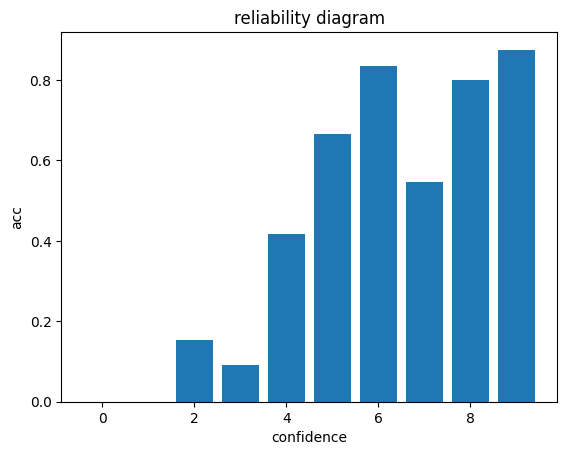

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(buckets, accs, label=buckets)
ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title('reliability diagram')

plt.show()

### Expected Calibration Error (ECE)

Prefer to have a scalar over a diagram

$ECE = \mathbb{E}_{\hat{p}} [\lvert P(\hat{y} = y | \hat{p} - p\rvert] = \sum_{m=1}^M \frac{\lvert B_m \rvert}{n} \vert acc(B_m) - conf(B_m) \vert $

In [37]:
# col_conf, y, y_hat
# data_array ....

ece = 0

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    bucket_size = len(idxs)
    conf = np.mean(data_array[idxs,0])
    ece += float(bucket_size/N) * abs(acc-conf)

print(ece)

0.1276720396349665


### What are some other ways to calibrate?

NLL, i.e. cross entropy loss, $ - \sum_{p(x)} \log q(x) $ , (Bengio et al 2015). According to (Friedman et al 2001), NLL is minimized iff $\hat{\pi}(y \vert x)$ recovers the ground truth conidtional distribution $\pi(y \vert x)$.

In practice, NLL, diverges from accuracy (Zhang et al 2017) so it is not a great calibration method in practice. 

### Platt Scaling and generalization to MultiClass Problems

What is **Platt scaling** (Platt et al, 1999)?

* A parametric approach to calibration
* The non-probabilistic predictions of a classifier are used as features for a logistic regression model, which is trained on the validation set to return probabilities
* I.e., learn $\hat{q_i} = \sigma(a z_i + b)$ as the calibrated probability using NLL over the validation set, while the NN parameters are fixed

### Matrix and vector scaling

* two multi-class extensions of Platt scaling. Apply linear transformation before the softmax
* $\hat{q_i} = max_k \sigma_{SM}(W z_i + b)$
* $\hat{y_i'} = argmax_k \sigma_{SM}(W z_i + b)$

* The parameters $W$ and $b$ are optimized wrt to NLL on the validation set.

### Temperature Scaling

